In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
import tensorflow.keras as layers

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    # Just an arbitrary pattern, you can change it if you wish
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    # repeat the same pattern at each period
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def white_noise(time,noise_level,seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

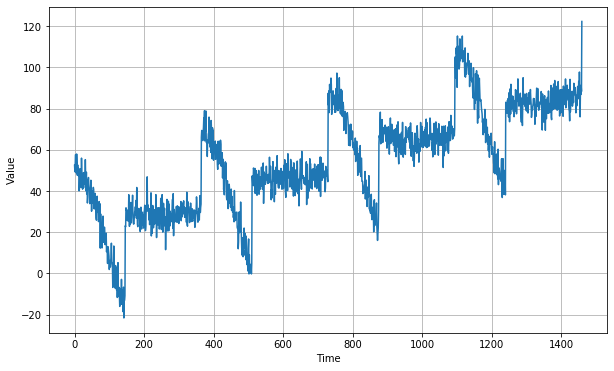

In [5]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude=40
series=seasonality(time,period=365,amplitude=amplitude)

slope=0.05
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

noise_level=5
noise=white_noise(time,noise_level,seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series);

In [6]:
# Forecasting

# Let's try to forecast it. We will split it into two periods:
# the training period and the validation period
# (in many cases, you would also want to have a test period).
# The split will be at time step 1000.

In [7]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [8]:
# Naive Forecasting

naive_forecast=series[split_time-1:-1]

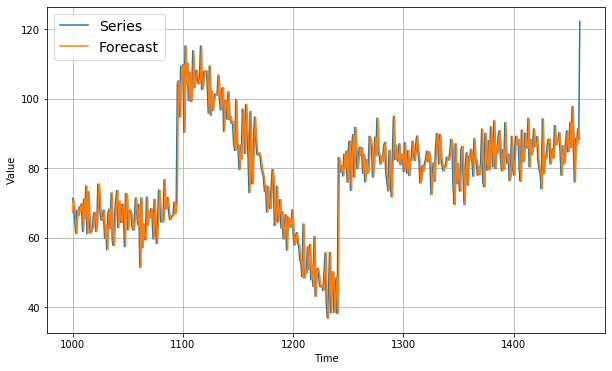

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid,label='Series');
plot_series(time_valid,naive_forecast,label='Forecast');

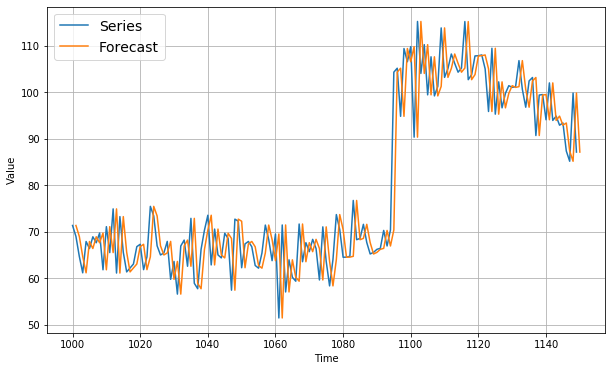

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid,start=0,end=150,label='Series');
plot_series(time_valid,naive_forecast,start=1,end=151,label='Forecast');

In [11]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy()

5.937908515321673

In [13]:
# Moving Average

In [14]:
def maf(series,windows_size):
    # Forecasts the meanof the last few values.
    # If window_size, then this is equivalent to naive forecast.
    forecast=[]
    for time in range(len(series)-window_size):
        forecast.append(series[time:time+window_size].mean())
    return np.array(forecast)

In [15]:
# A faster constellation for Moving Average Forecast

def maf(series, window_size):
    # Forecasts the mean of the last few values.
    # If window_size=1, then this is equivalent to naive forecast
    # This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

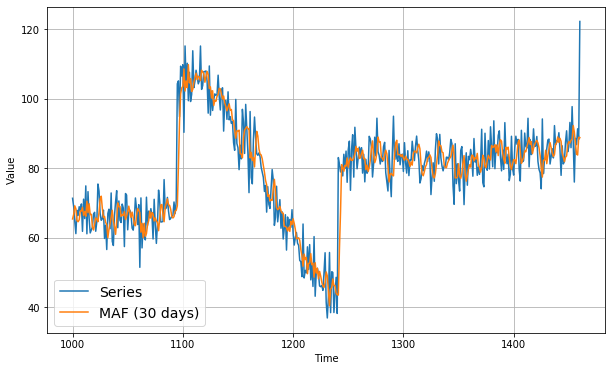

In [16]:
moving_avg=maf(series,3)[split_time-3:]

plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid,label='Series');
plot_series(time_valid,moving_avg,label='MAF (30 days)');

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()

4.818170669137199

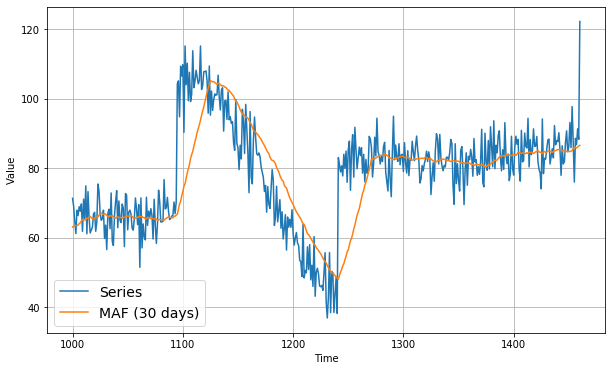

In [18]:
moving_avg=maf(series,30)[split_time-30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid,label='Series');
plot_series(time_valid,moving_avg,label='MAF (30 days)');

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()

7.1424185706207854

In [20]:
# The moving average does not anticipate trend or seasonality,
# so let's try to remove them by using differencing.
# Since the seasonality period is 365 days, we will subtract
# the value at time t – 365 from the value at time t.

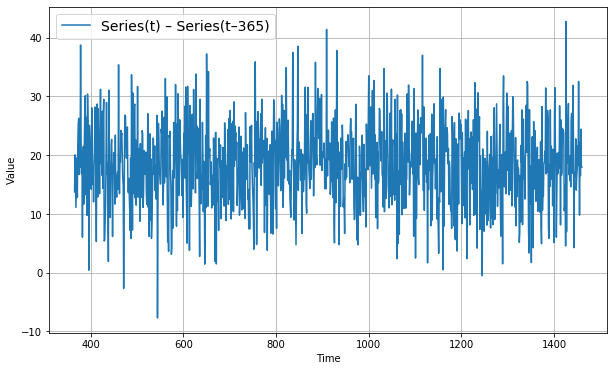

In [21]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

In [22]:
# Focusing on the validation period:

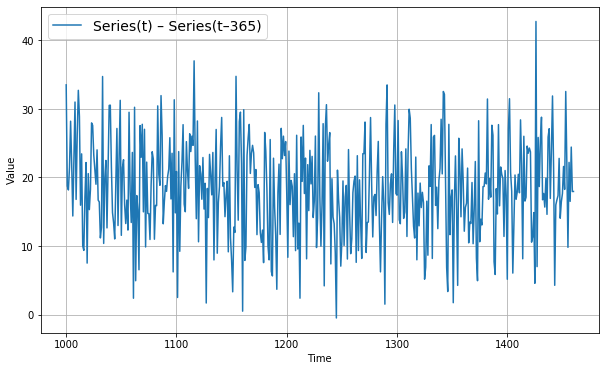

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid,diff_series[split_time-365:],label="Series(t) – Series(t–365)")

In [24]:
# Great, the trend and seasonality seem to be gone, so now we can use the moving average:

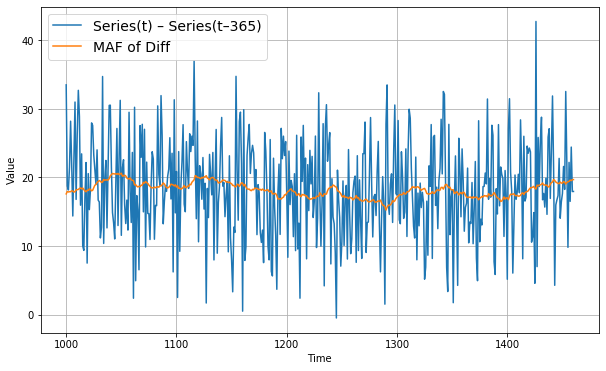

In [25]:
diff_moving_avg=maf(diff_series,50)[split_time-365-50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid,diff_series[split_time-365:],label="Series(t) – Series(t–365)");
plot_series(time_valid,diff_moving_avg,label='MAF of Diff');

In [26]:
# Now let's bring back the trend and seasonality by adding the past values from t – 365:

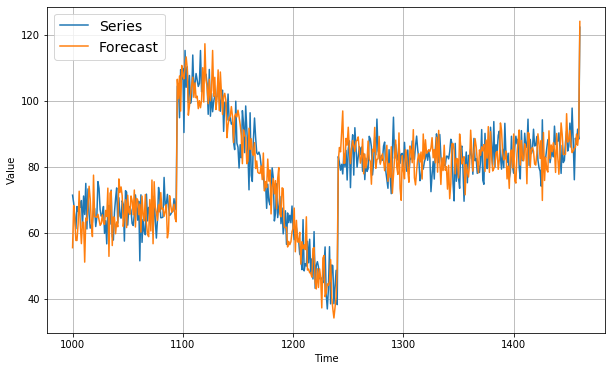

In [27]:
diff_moving_avg_plus_past=series[split_time-365:-365]+diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid,label="Series");
plot_series(time_valid,diff_moving_avg_plus_past,label='Forecast');

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy()

5.8393105629958955

In [29]:
# Better than naive forecast, good. However the forecasts look a bit too random,
# because we're just adding past values, which were noisy.
# Let's use a moving averaging on past values to remove some of the noise:

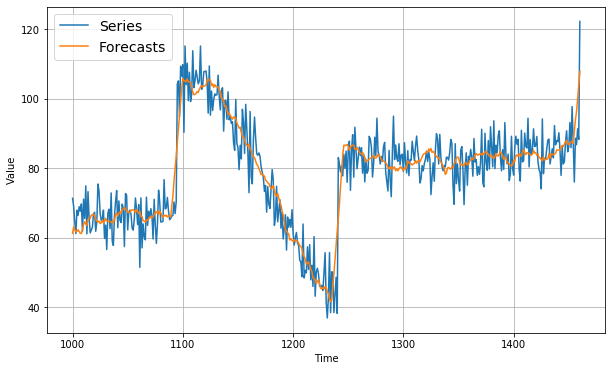

In [30]:
diff_moving_avg_plus_smooth_past = maf(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts");

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772